In [ ]:
from models.VAE import VAE
import torch
from data.dataset import MNIST_Dataset, CIFAR10_Dataset, Dataset
from utils.utils import show_image
import torch
import torch.nn as nn


cfg = {
    "image_size": 64,
    "channels": 3,
    "latent_dim": 128,
    "dataset": "celeba",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 1e-3,
    "n_epochs_kl_annealing": 5,
    "depth": 3,
    "beta": 2.0,
    "eval_every": 1
}

model_path = f"vae_{cfg['dataset']}.pth"

In [2]:
import wandb

run = wandb.init(
    entity="lorrain",
    project="Diffusion VAE",
    config=cfg
)

wandb: Currently logged in as: lorrain-morlet (lorrain) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
latent_dim = cfg['latent_dim']
c = cfg['channels']
depth = cfg['depth']

model = VAE(latent_dim=latent_dim, initial_channels=c, depth=depth)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(model)

VAE(
  (encoder): VAEEncoder(
    (down_blocks): ModuleList(
      (0): DownBlock(
        (silu): SiLU()
        (convs): ModuleList(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norms): ModuleList(
          (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (dropouts): ModuleList(
          (0-1): 2 x Dropout(p=0.0, inplace=False)
        )
        (max_pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): DownBlock(
        (silu): SiLU()
        (convs): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norms): ModuleList(
          (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track

: 

In [ ]:
# test with a random tensor
x = torch.randn(1, 3, 64, 64).to(device)
x, mu, logvar, z = model(x, verbose=1)

print(x.shape, mu.shape, logvar.shape, z.shape)

VAE input shape: torch.Size([1, 3, 64, 64])
Encoder input shape: torch.Size([1, 3, 64, 64])
Encoder down block 0, input shape: torch.Size([1, 3, 64, 64])
DownBlock input shape: torch.Size([1, 3, 64, 64])


Latent space representation: [B, 64, 8, 8]

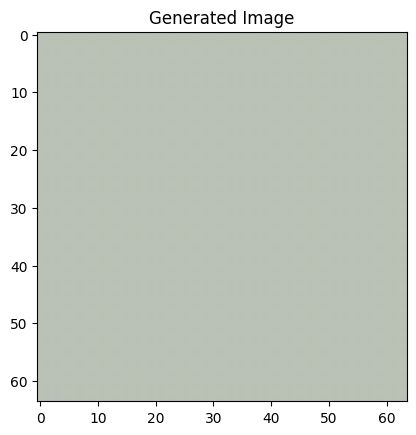

In [ ]:
latent_shape = (1, latent_dim, 8, 8)

def generate_images(model, num_images=5):
    model.eval()
    with torch.no_grad():
        for _ in range(num_images):
            z = torch.randn(latent_shape).to(device)
            recon_img = model.decode(z)
            show_image(recon_img.squeeze(0).cpu(), title="Generated Image", unnormalize=True)

generate_images(model, num_images=1)

Files already downloaded and verified
torch.Size([3, 64, 64])


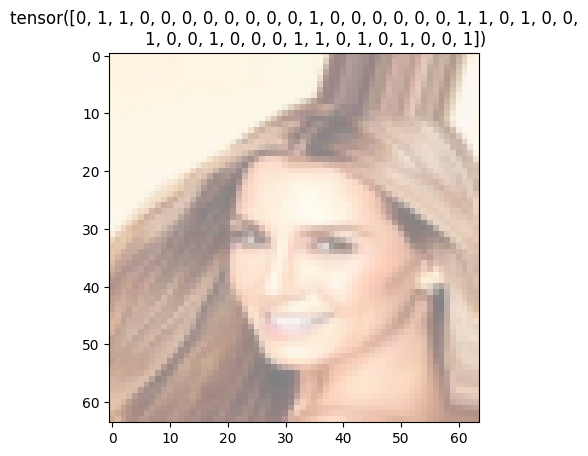

Files already downloaded and verified
torch.Size([3, 64, 64])


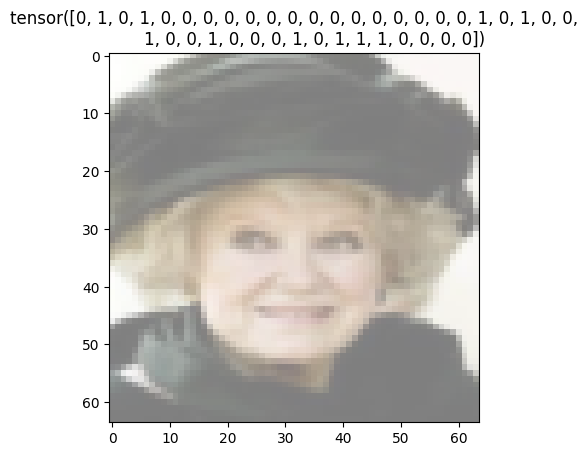

In [ ]:
import torch.nn as nn
from torchvision import transforms

img_size = cfg['image_size']
c = cfg['channels']
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

# train = CIFAR10_Dataset(split='train', transform=transform)
# train = MNIST_Dataset(split='train', transform=transform)

train = Dataset('CELEBA', split='train', transform=transform)
print(train[0][0].shape)
show_image(train[0][0], title=train[0][1])

test = Dataset('CELEBA', split='test', transform=transform)
print(test[0][0].shape)
show_image(test[0][0], title=test[0][1])

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

train_loader = DataLoader(train, batch_size=cfg['batch_size'], shuffle=True, num_workers=2)
test_loader = DataLoader(test, batch_size=cfg['batch_size'], shuffle=False, num_workers=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1.5, eta_min=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)


In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0, epoch=0, max_anneal_epochs=10):
    # print(recon_x.shape, x.shape)
    # print("recon_x min/max:", recon_x.min().item(), recon_x.max().item())
    # print("x min/max:", x.min().item(), x.max().item())
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    # print("recon_loss:", recon_loss.item(), "kl_loss:", kl_loss.item())
    if epoch < max_anneal_epochs:
        beta = beta * epoch / max_anneal_epochs
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    with torch.no_grad():
        for x, _ in tqdm(dataloader, desc="Evaluating", leave=False):
            x = x.to(device)
            recon_x, mu, logvar, _ = model(x)
            loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, logvar, beta=cfg['beta'])
            total_loss += loss.item() * x.size(0)
            recon_loss_total += recon_loss.item() * x.size(0)
            kl_loss_total += kl_loss.item() * x.size(0)
    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon_loss = recon_loss_total / len(dataloader.dataset)
    avg_kl_loss = kl_loss_total / len(dataloader.dataset)
    return avg_loss, avg_recon_loss, avg_kl_loss

In [ ]:
def train_vae(model, train_loader,optimizer, epochs=20):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        for images, _ in progress_bar:
            # print(images.shape)
            images = images.to(device)
            recon, mu, logvar, z = model(images)

            loss, recon_loss, kl_loss = vae_loss(recon, images, mu, logvar, beta=cfg['beta'], epoch=epoch, max_anneal_epochs=cfg['n_epochs_kl_annealing'])
            # show_image(images[0], title=f"Input Image, loss : {loss.item():.4f}")
            # show_image(recon[0], title=f"Reconstructed Image, loss : {loss.item():.4f}")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            wandb.log({
                "batch/total_loss": loss.item(),
                "batch/recon_loss": recon_loss.item(),
                "batch/kl_loss": kl_loss.item(),
                "batch/lr": scheduler.get_last_lr()[0]
            })

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)

        # Log epoch-level metrics to wandb
        wandb.log({
            "epoch/total_loss": avg_epoch_loss,
            "epoch/recon_loss": recon_loss.item(),
            "epoch/kl_loss": kl_loss.item(),
            "epoch/lr": scheduler.get_last_lr()[0]
        })
        
        if cfg['eval_every'] > 0 and (epoch + 1) % cfg['eval_every'] == 0:
            val_loss, val_recon_loss, val_kl_loss = evaluate(model, test_loader)
            wandb.log({
                "val/total_loss": val_loss,
                "val/recon_loss": val_recon_loss,
                "val/kl_loss": val_kl_loss
            })
            progress_bar.set_postfix(loss=avg_epoch_loss, val_loss=val_loss, val_recon_loss=val_recon_loss, val_kl_loss=val_kl_loss)
            print(f"Epoch {epoch+1}/{epochs}, : Validation - Loss: {val_loss:.4f}, recon_loss: {val_recon_loss:.4f}, kl_loss: {val_kl_loss:.4f}\n Train - Loss: {avg_epoch_loss:.4f}, recon_loss: {recon_loss.item():.4f}, kl_loss: {kl_loss.item():.4f}, lr: {scheduler.get_last_lr()[0]:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model_best = model.state_dict()
                torch.save(model_best, model_path)
            
        if epoch % 2 == 0:
            wandb.log({
                "input_image": wandb.Image(images[0].cpu()),
                "reconstructed_image": wandb.Image(recon[0].cpu())
            })
            
            # break
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}, recon_loss: {recon_loss.item():.4f}, kl_loss: {kl_loss.item():.4f}, lr: {scheduler.get_last_lr()[0]:.6f}")
        scheduler.step()
        
    return model_best

model_best = train_vae(model, train_loader, optimizer, epochs=50)


Epoch 1/50, Loss: 0.0077, recon_loss: 0.0048, kl_loss: 5.8336, lr: 0.001000


Epoch 2/50, Loss: 0.0303, recon_loss: 0.0157, kl_loss: 0.0191, lr: 0.001000


Epoch 3/50, Loss: 0.0279, recon_loss: 0.0174, kl_loss: 0.0123, lr: 0.000950


Epoch 4/50, Loss: 0.0315, recon_loss: 0.0185, kl_loss: 0.0094, lr: 0.000950


Epoch 5/50, Loss: 0.0345, recon_loss: 0.0239, kl_loss: 0.0080, lr: 0.000902


Epoch 6/50, Loss: 0.0369, recon_loss: 0.0291, kl_loss: 0.0062, lr: 0.000902


Epoch 7/50, Loss: 0.0366, recon_loss: 0.0261, kl_loss: 0.0060, lr: 0.000857


Epoch 8/50, Loss: 0.0363, recon_loss: 0.0222, kl_loss: 0.0057, lr: 0.000857


Epoch 9/50, Loss: 0.0358, recon_loss: 0.0256, kl_loss: 0.0057, lr: 0.000815


Epoch 10/50, Loss: 0.0354, recon_loss: 0.0244, kl_loss: 0.0057, lr: 0.000815


Epoch 11/50, Loss: 0.0349, recon_loss: 0.0289, kl_loss: 0.0056, lr: 0.000774


Epoch 12/50, Loss: 0.0346, recon_loss: 0.0258, kl_loss: 0.0056, lr: 0.000774


Epoch 13/50, Loss: 0.0343, recon_loss: 0.0245, kl_loss: 0.0055, lr: 0.000735


Epoch 14/50, Loss: 0.0341, recon_loss: 0.0222, kl_loss: 0.0055, lr: 0.000735


Epoch 15/50, Loss: 0.0339, recon_loss: 0.0197, kl_loss: 0.0053, lr: 0.000698


Epoch 16/50, Loss: 0.0338, recon_loss: 0.0231, kl_loss: 0.0055, lr: 0.000698


Epoch 17/50, Loss: 0.0336, recon_loss: 0.0202, kl_loss: 0.0052, lr: 0.000663


Epoch 18/50, Loss: 0.0336, recon_loss: 0.0225, kl_loss: 0.0053, lr: 0.000663


Epoch 19/50, Loss: 0.0335, recon_loss: 0.0252, kl_loss: 0.0053, lr: 0.000630


Epoch 20/50, Loss: 0.0334, recon_loss: 0.0204, kl_loss: 0.0054, lr: 0.000630


Epoch 21/50, Loss: 0.0333, recon_loss: 0.0253, kl_loss: 0.0054, lr: 0.000599


Epoch 22/50, Loss: 0.0333, recon_loss: 0.0238, kl_loss: 0.0053, lr: 0.000599


Epoch 23/50, Loss: 0.0332, recon_loss: 0.0207, kl_loss: 0.0049, lr: 0.000569


Epoch 24/50, Loss: 0.0332, recon_loss: 0.0234, kl_loss: 0.0055, lr: 0.000569


Epoch 25/50, Loss: 0.0331, recon_loss: 0.0228, kl_loss: 0.0051, lr: 0.000540


Epoch 26/50, Loss: 0.0331, recon_loss: 0.0204, kl_loss: 0.0051, lr: 0.000540


Epoch 27/50, Loss: 0.0330, recon_loss: 0.0211, kl_loss: 0.0053, lr: 0.000513


Epoch 28/50, Loss: 0.0330, recon_loss: 0.0276, kl_loss: 0.0054, lr: 0.000513


Epoch 29/50, Loss: 0.0329, recon_loss: 0.0220, kl_loss: 0.0049, lr: 0.000488


Epoch 30/50, Loss: 0.0329, recon_loss: 0.0204, kl_loss: 0.0052, lr: 0.000488


Epoch 31/50, Loss: 0.0328, recon_loss: 0.0230, kl_loss: 0.0052, lr: 0.000463


Epoch 32/50, Loss: 0.0328, recon_loss: 0.0205, kl_loss: 0.0050, lr: 0.000463


Epoch 33/50, Loss: 0.0328, recon_loss: 0.0257, kl_loss: 0.0052, lr: 0.000440


Epoch 34/50, Loss: 0.0327, recon_loss: 0.0213, kl_loss: 0.0051, lr: 0.000440


Epoch 35/50, Loss: 0.0327, recon_loss: 0.0226, kl_loss: 0.0050, lr: 0.000418


Epoch 36/50, Loss: 0.0327, recon_loss: 0.0231, kl_loss: 0.0052, lr: 0.000418


Epoch 37/50, Loss: 0.0326, recon_loss: 0.0229, kl_loss: 0.0053, lr: 0.000397


Epoch 38/50, Loss: 0.0326, recon_loss: 0.0212, kl_loss: 0.0052, lr: 0.000397


Epoch 39/50, Loss: 0.0326, recon_loss: 0.0262, kl_loss: 0.0053, lr: 0.000377


Epoch 40/50, Loss: 0.0326, recon_loss: 0.0219, kl_loss: 0.0052, lr: 0.000377


Epoch 41/50, Loss: 0.0325, recon_loss: 0.0205, kl_loss: 0.0048, lr: 0.000358


Epoch 42/50, Loss: 0.0325, recon_loss: 0.0215, kl_loss: 0.0049, lr: 0.000358


Epoch 43/50, Loss: 0.0325, recon_loss: 0.0250, kl_loss: 0.0051, lr: 0.000341


Epoch 44/50, Loss: 0.0325, recon_loss: 0.0202, kl_loss: 0.0051, lr: 0.000341


Epoch 45/50, Loss: 0.0324, recon_loss: 0.0214, kl_loss: 0.0051, lr: 0.000324


Epoch 46/50, Loss: 0.0324, recon_loss: 0.0214, kl_loss: 0.0052, lr: 0.000324


Epoch 47/50, Loss: 0.0324, recon_loss: 0.0254, kl_loss: 0.0050, lr: 0.000307


Epoch 48/50, Loss: 0.0324, recon_loss: 0.0247, kl_loss: 0.0051, lr: 0.000307


Epoch 49/50, Loss: 0.0324, recon_loss: 0.0249, kl_loss: 0.0053, lr: 0.000292


Epoch 50/50, Loss: 0.0324, recon_loss: 0.0210, kl_loss: 0.0050, lr: 0.000292


In [ ]:
# model.load_state_dict(torch.load(model_path))
# model.eval()

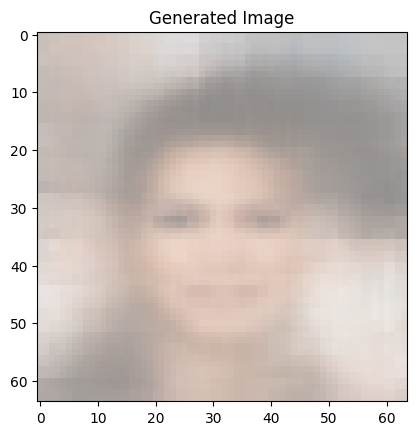

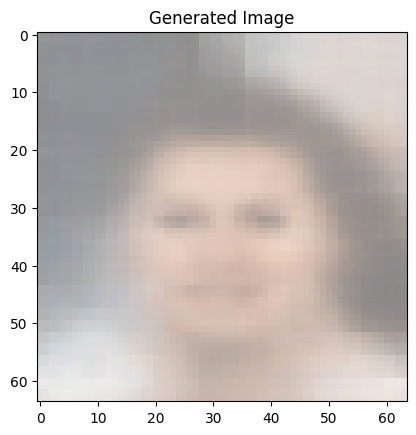

In [ ]:
generate_images(model, num_images=2)

In [ ]:
img = train[5][0].unsqueeze(0).to(device)
recon, mu, logvar, z = model(img)
print(torch.mean((img - recon) ** 2).item())
show_image(img.squeeze(0).cpu(), title="Original Image")
show_image(recon.squeeze(0).cpu(), title="Reconstructed Image")

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# z.shape = [batch_size, latent_dim, H, W]
latent_mean = torch.mean(z, dim=[0, 2, 3]).item()  # Should be ~0
latent_std = torch.std(z, dim=[0, 2, 3]).mean().item()  # Should be ~1
latent_l2 = torch.norm(z, p=2, dim=1).mean().item()  # Should be ~√(latent_dim)

print(f"Mean distance to 0: {latent_mean.item()}")
print(f"Mean std deviation: {latent_std.item()}")
print(f"Mean L2 norm: {latent_l2.item()}")

Mean distance to 0: 4.903605937957764


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Assume `encoder` is your VAE's encoder and `x` is a batch of input data
def plot_latent_space(encoder, x, y=None, latent_dim=2):
    enc_out = encoder(x)
    with torch.no_grad():
        if isinstance(enc_out, tuple):
            mu, _ = enc_out  # Assuming encoder outputs (mu, logvar)
        else:
            mu = enc_out[:, :latent_dim]
            logvar = enc_out[:, latent_dim:]

    mu = mu.detach().cpu().numpy()

    if latent_dim > 2:
        pca = PCA(n_components=2)
        mu = pca.fit_transform(mu)
    print(mu)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(mu[:, 0], mu[:, 1], c=y, cmap='viridis', alpha=0.6, edgecolors='k')
    plt.colorbar(scatter, label='Class' if y is not None else 'Value')
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

# Example usage:
images, labels = zip(*[train[i] for i in range(1000)])
images = torch.stack(images).float().to(device) / 255.0  # Normalize and move to device
images = images.view(images.size(0), 3, 64, 64)  # Reshape the images to match the input size of the encoder
labels = torch.tensor(labels)

plot_latent_space(model.encoder, images, y=labels, latent_dim=latent_dim)


TypeError: only integer tensors of a single element can be converted to an index